In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Response和Signaling的散点图

In [7]:
celltype = 'Neutrophils'
sample = 'NSCLC_GSE127465'

if celltype == 'CD8T':
    signature = 'Prolifertion'
    celltype_in_column = 'CD8T'
    celltype_in_file = 'CD8T'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-1.Prolifertion/{sample}.csv'
elif celltype == 'Macrophage':
    signature = 'Polarization'
    celltype_in_column = 'Mono/Macro'
    celltype_in_file = 'Mono_Macro'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-2.Polarization/{sample}.csv'
elif celltype == 'Neutrophils':
    signature = 'Neutrophils_signature'
    celltype_in_column = 'Neutrophils'
    celltype_in_file = 'Neutrophils'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-3.Neutrophils_response/{sample}.csv'
    # response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/1.neutrophil_data/Gao2024/Gao2024.response.csv'

signaling_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/2.Signaling/{sample}.csv'
# signaling_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/1.neutrophil_data/Gao2024/Gao2024.signaling.csv'
signaling_data = pd.read_csv(signaling_path, delimiter='\t', index_col=0, header=0)
celltype_list = [v.split('.')[0] for v in signaling_data.columns]
filter_flag = [v for v in signaling_data.columns if v.split('.')[0] == celltype_in_column]
signaling_data = signaling_data[filter_flag]

response_data = pd.read_csv(response_path, delimiter='\t', index_col=0, header=0)

signaling_data.shape, response_data.shape

((51, 3345), (2, 3345))

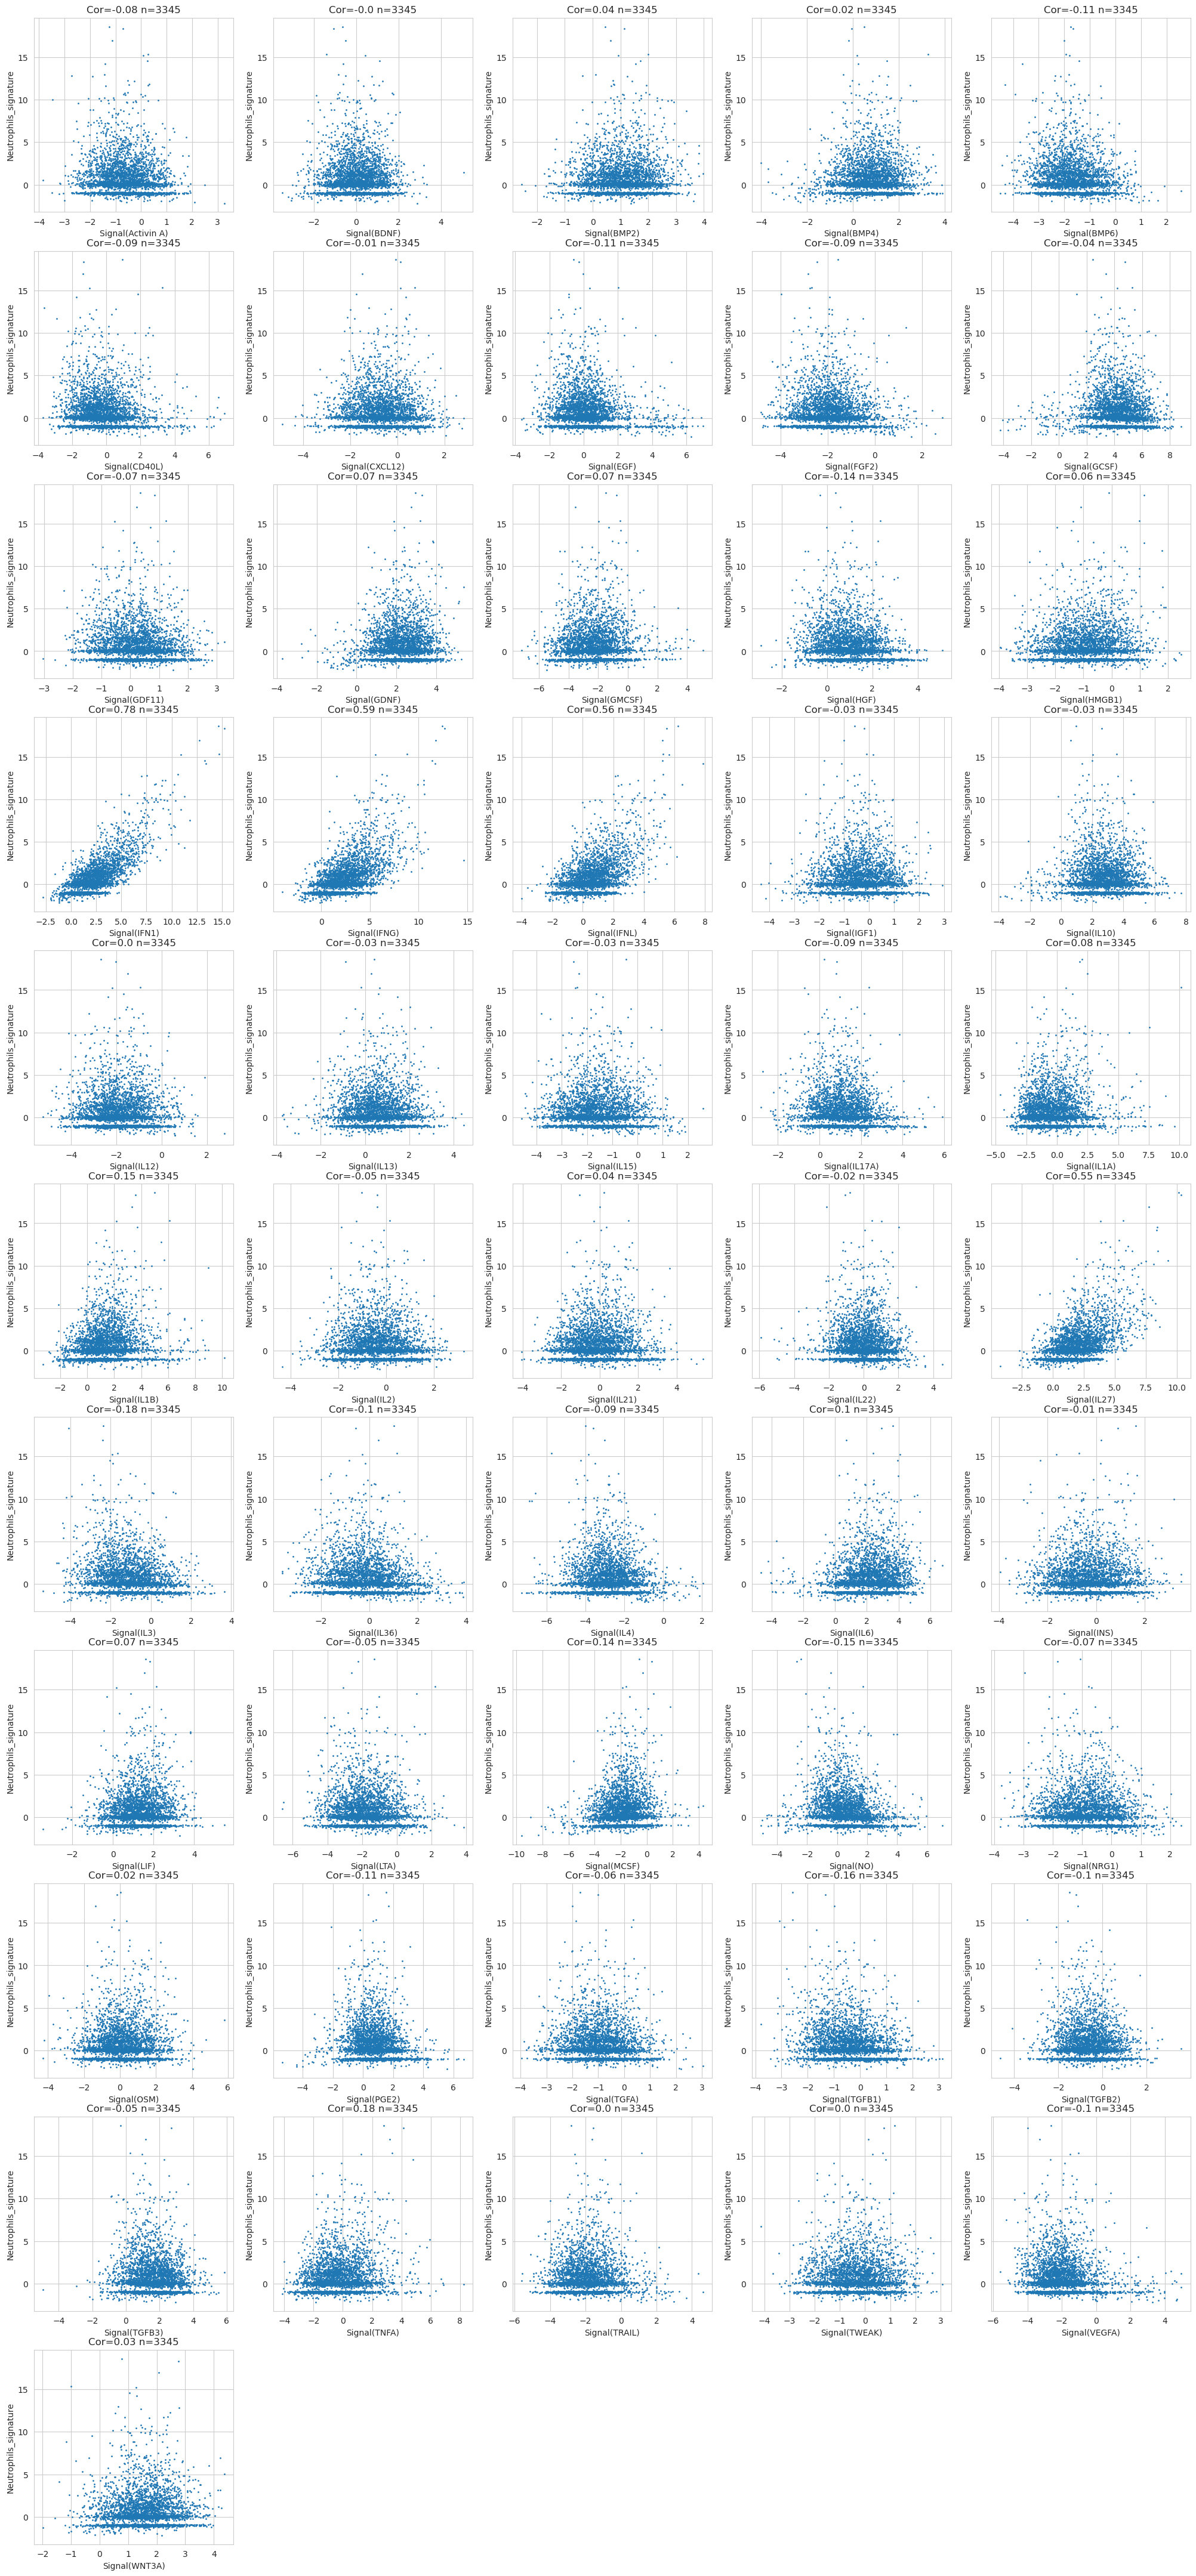

In [8]:
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr

fig = plt.figure(figsize=(25, 55))
ncols, nrows = 5, 11
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, width_ratios=[1] * ncols, height_ratios=[1] * nrows)

y = response_data.loc[signature]
i = 0
for cytokine in list(signaling_data.index):
    col = i % 5
    row = int(i / 5)
    ax = fig.add_subplot(gs[row, col])

    x = signaling_data.loc[cytokine]
    
    # x_normalized = (x - min(x)) / (max(x) - min(x))
    # y_normalized = (y - min(y)) / (max(y) - min(y))
    correlation, _ = pearsonr(x, y)
    
    ax.scatter(x, y, s=1)
    ax.set_xlabel(f'Signal({cytokine})')
    ax.set_ylabel(signature)
    ax.set_title(f'Cor={round(correlation, 2)} n={len(x)}')
    i += 1
plt.show()

## Response和Signaling相关性系数总结

/var/tmp/ipykernel_190588/3012501282.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  histplot.set_yticklabels(histplot.get_yticks(), size = 15)


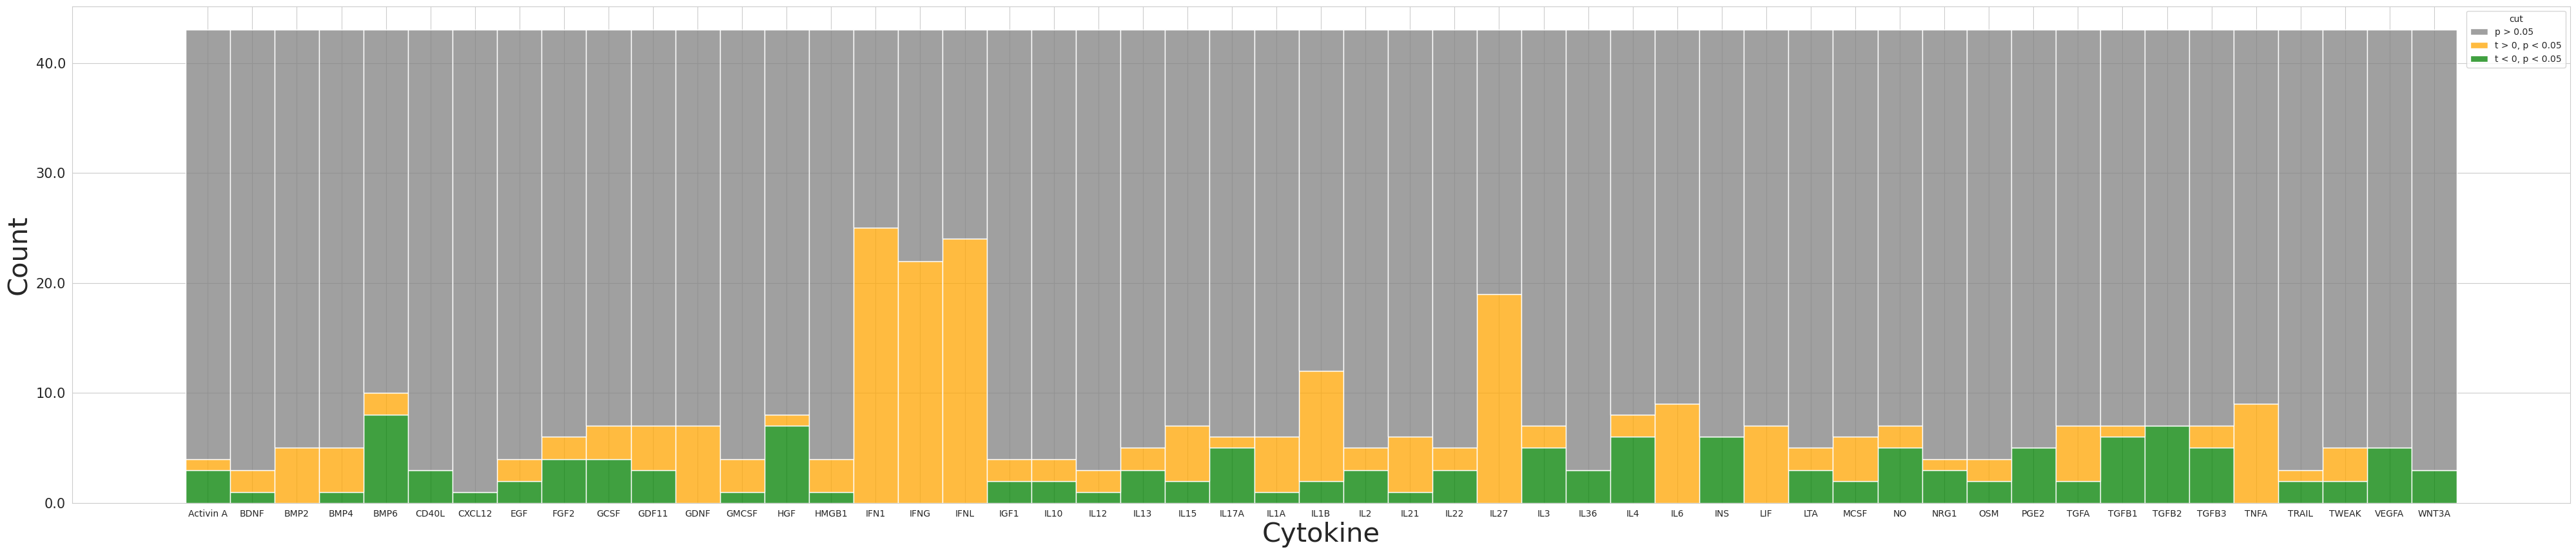

In [10]:
celltype = 'Neutrophils'
qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.{celltype}.csv'
# qc_result_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/1.neutrophil_data/Gao2024/qc_result.Neutrophils.csv'
qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return "t > 0, p < 0.05"
    elif x.t <= 0 and x.p <= 0.05:
        return "t < 0, p < 0.05"
    elif x.p > 0.05:
        return "p > 0.05"
qc_result_data['cut'] = qc_result_data.apply(lambda x: get_group(x), axis=1)

fig = plt.figure(figsize=(50, 10))
histplot = sns.histplot(data=qc_result_data, x="Cytokine", hue="cut", multiple="stack", 
                        palette={'t > 0, p < 0.05':'orange', 't < 0, p < 0.05':'green', 'p > 0.05':'grey'})
histplot.xaxis.label.set_size(30)
histplot.yaxis.label.set_size(30)
histplot.set_yticklabels(histplot.get_yticks(), size = 15)
plt.show()

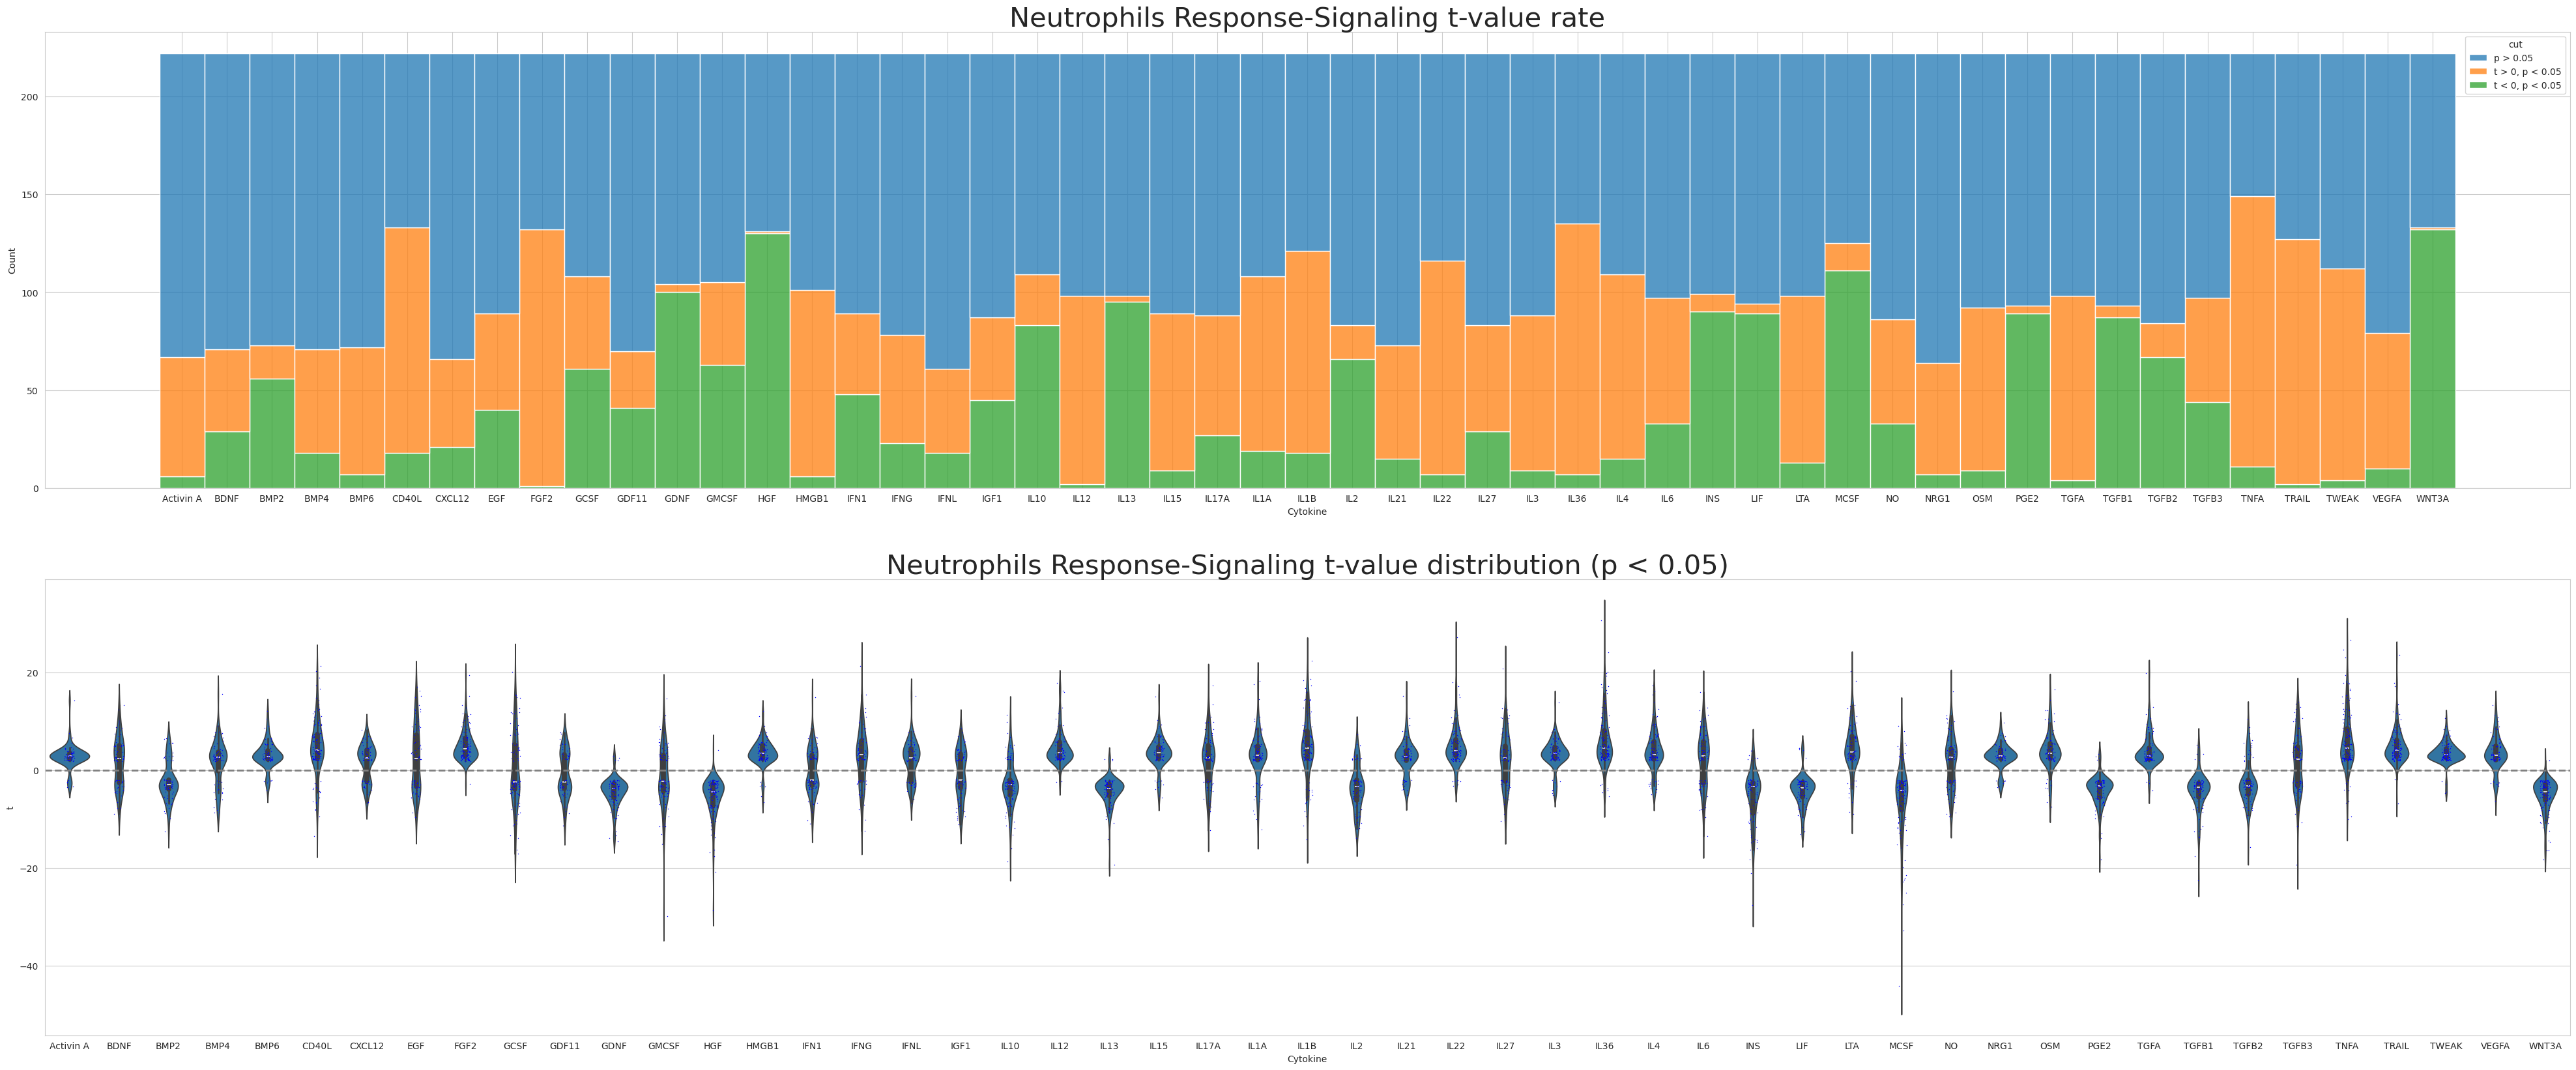

In [23]:
# celltype = 'Neutrophils'
# qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.{celltype}.csv'
# qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)

fig, axes = plt.subplots(2, 1, figsize=(50, 20))

sns.histplot(data=qc_result_data, x="Cytokine", hue="cut", multiple="stack", color='blue', ax=axes[0])
axes[0].set_title(f"{celltype} Response-Signaling t-value rate", size=30)

qc_result_data_filtered = qc_result_data[qc_result_data['p'] <= 0.05]
sns.violinplot(x="Cytokine", y="t", data=qc_result_data_filtered, ax=axes[1])
sns.stripplot(x="Cytokine", y="t", data=qc_result_data_filtered, color='b', size=1, ax=axes[1])
axes[1].axhline(0, color='grey', linestyle='--', linewidth=2)
axes[1].set_title(f"{celltype} Response-Signaling t-value distribution (p < 0.05)", size=30)
plt.show()

## Cytokine相关性小于0占比排序

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy

celltype = 'CD8T'
qc_result_path1 = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/1.paper_data/3.qc_result/qc_result.CD8T.csv'
qc_result_path2 = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.CD8T.csv'
qc_result_data1 = pd.read_csv(qc_result_path1, sep="\t", header=0)
qc_result_data2 = pd.read_csv(qc_result_path2, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return 0
    elif x.t <= 0 and x.p <= 0.05:
        return 1
    elif x.p > 0.05:
        return -1

qc_result_data1['cut'] = qc_result_data1.apply(lambda x: get_group(x), axis=1)
qc_result_data2['cut'] = qc_result_data2.apply(lambda x: get_group(x), axis=1)
qc_result_filtered1 = qc_result_data1[qc_result_data1['cut'] >= 0]
qc_result_filtered2 = qc_result_data2[qc_result_data2['cut'] >= 0]

qc_result_groupby_Cytokine1 = qc_result_filtered1.groupby('Cytokine')
qc_result_groupby_Cytokine2 = qc_result_filtered2.groupby('Cytokine')

cut_mean1 = qc_result_groupby_Cytokine1['cut'].mean()
cut_mean2 = qc_result_groupby_Cytokine2['cut'].mean()

X = cut_mean1.values
Y = cut_mean2.values
label = cut_mean1.index

# save the t<0 rate rank
rank_table = pd.DataFrame(index=label, columns=['Cohort_rank', 'Tisch_rank', 'average'])
Cohort_rank = scipy.stats.rankdata(X, method='min')
Tisch_rank = scipy.stats.rankdata(Y, method='min')
average = (Cohort_rank + Tisch_rank) / 2
rank_table['Cohort_rank'] = Cohort_rank
rank_table['Tisch_rank'] = Tisch_rank
rank_table['average'] = average
rank_table_sort = rank_table.sort_values(by='average')
rank_table_sort.to_csv(f"/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/Rank.{celltype}.csv")

fig = plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
for i in range(len(X)):
    plt.annotate(label[i], xy = (X[i], Y[i]), xytext = (X[i], Y[i]), fontsize = 5)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Cohort_Tisch Cytokine t<0 rate')
plt.xlabel('Cohort')
plt.ylabel('Tisch')
plt.show()

In [4]:
celltype = 'Neutrophils'
qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.{celltype}.csv'
qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return 0
    elif x.t <= 0 and x.p <= 0.05:
        return 1
    elif x.p > 0.05:
        return -1

qc_result_data['negative_rate'] = qc_result_data.apply(lambda x: get_group(x), axis=1)
qc_result_filtered = qc_result_data[qc_result_data['negative_rate'] >= 0]
negative_rate = qc_result_filtered.groupby('Cytokine')['negative_rate'].mean()
negative_rate.sort_values(ascending=False, inplace=True)
negative_rate.to_csv(f"/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/Rank.{celltype}.csv")
negative_rate

Cytokine
WNT3A        0.992481
HGF          0.992366
IL13         0.969388
GDNF         0.961538
PGE2         0.956989
LIF          0.946809
TGFB1        0.935484
INS          0.909091
MCSF         0.888000
TGFB2        0.797619
IL2          0.795181
BMP2         0.767123
IL10         0.761468
GMCSF        0.600000
GDF11        0.585714
GCSF         0.564815
IFN1         0.539326
IGF1         0.517241
TGFB3        0.453608
EGF          0.449438
BDNF         0.408451
NO           0.383721
IL27         0.349398
IL6          0.340206
CXCL12       0.318182
IL17A        0.306818
IFNL         0.295082
IFNG         0.294872
BMP4         0.253521
IL21         0.205479
IL1A         0.175926
IL1B         0.148760
IL4          0.137615
CD40L        0.135338
LTA          0.132653
VEGFA        0.126582
NRG1         0.109375
IL3          0.102273
IL15         0.101124
OSM          0.097826
BMP6         0.097222
Activin A    0.089552
TNFA         0.073826
IL22         0.060345
HMGB1        0.059406
I